In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold
from scipy.stats import uniform,loguniform
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, f1_score


In [2]:
cancer = load_breast_cancer()

# 5. Размер контрольного множества

In [13]:
#Разбивка данных на обчающий и тестовый наборы с разной величиной контрольной выборки
def procent_of_test_size(control_sizes, data, target):
    scores = []
    data_strucrure = {'%_test_size': ['original'],  # формируем имена колонок
                      'train_size':[cancer.data.shape[0]],
                      'test_size': [cancer.data.shape[0]] , 
                      'mean': [round(np.mean(data))] , 
                      'var': [round(np.var(data))] ,
                      'score': [0]}
    df = pd.DataFrame(data_strucrure)        # создаем датафрейм 
      
    for size in control_sizes:
        train_size = 1 - size
        test_percent = size*100
        X_trainval, X_test, y_trainval, y_test = train_test_split(data, target, 
                                                                  stratify = target, 
                                                                  random_state = 0,
                                                                  test_size = size,
                                                                  train_size = train_size)
        train_size = X_trainval.shape 
        test_size = X_test.shape
        mean = np.mean(X_trainval)
        var = np.var(X_trainval)
    
        
        log_reg = LogisticRegression(C = 10.04, max_iter = 10000)
        kf = KFold(n_splits=12)
        scor = cross_val_score(log_reg, X_trainval, y_trainval, cv = kf)
        score = np.mean(scor)
        scores.append(score)
    
    
        new_row = {'%_test_size': test_percent, 
                   'train_size': train_size[0], 
                   'test_size': test_size[0], 
                   'mean': round(mean,2), 
                   'var': round(var,2),
                   'score': round(score,3)}
        
        
        df = df.append(new_row, ignore_index=True)
    
    return df

In [14]:
control_sizes = np.arange(0.01,1,0.1)
cancer_data_df = procent_of_test_size(control_sizes,cancer.data, cancer.target )

In [15]:
print(cancer_data_df)

   %_test_size  train_size  test_size   mean       var  score
0     original       569.0      569.0  62.00  52120.00  0.000
1            1       563.0        6.0  61.92  52150.42  0.959
2           11       506.0       63.0  62.15  53072.78  0.957
3           21       449.0      120.0  61.81  52628.14  0.960
4           31       392.0      177.0  61.60  52321.65  0.969
5           41       335.0      234.0  62.02  53842.41  0.949
6           51       278.0      291.0  62.18  54637.40  0.946
7           61       221.0      348.0  62.29  55988.48  0.941
8           71       165.0      404.0  60.81  51975.95  0.957
9           81       108.0      461.0  60.17  52199.24  0.944
10          91        51.0      518.0  57.15  40691.82  0.938


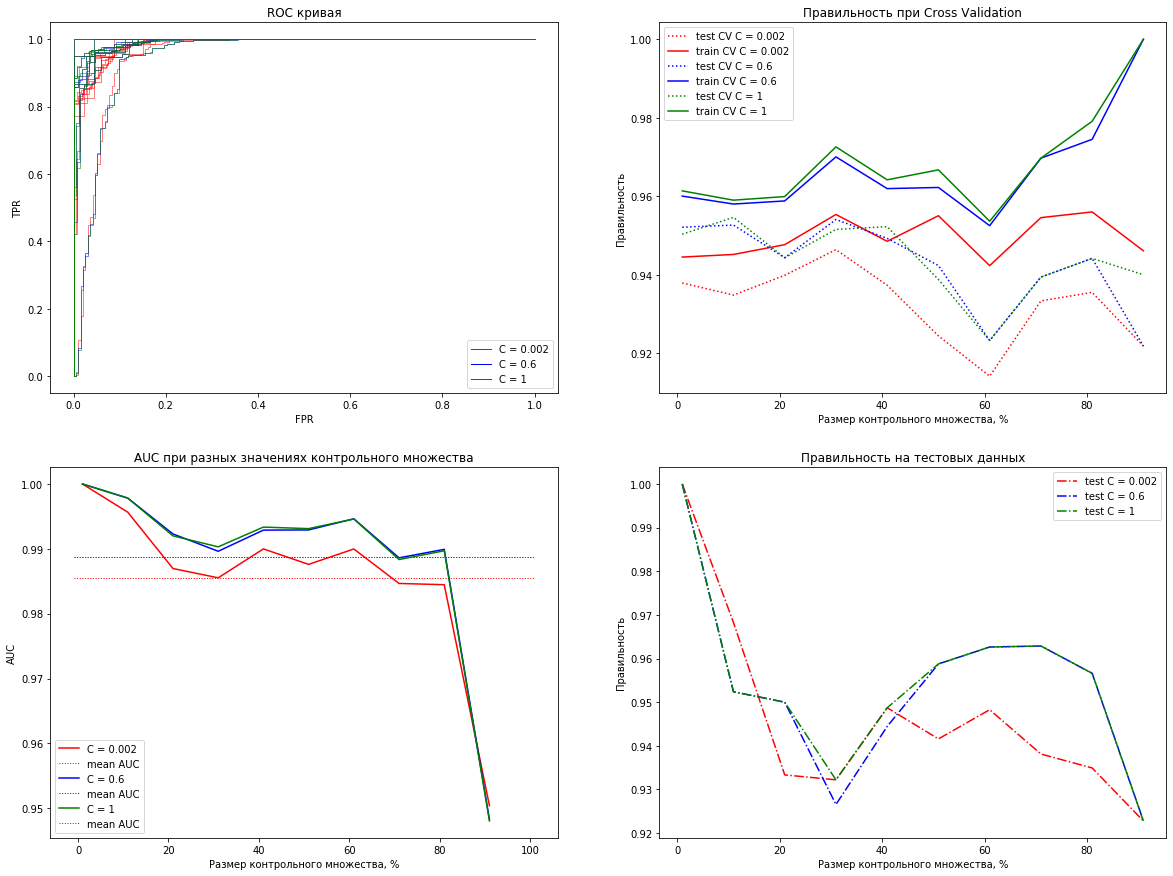

In [18]:
gridsize = (2,2)
fig = plt.figure(figsize=(20, 15))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 1))
ax4 = plt.subplot2grid(gridsize, (1, 0))

control_sizes = np.arange(0.01,1,0.1)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='r', lw=1),
               Line2D([0], [0], color='b', lw=1),
               Line2D([0], [0], color='g', lw=1)]

for c, col in zip([0.002, 0.6, 1],['r','b','g']):
    scores_test = []
    scores_train = []
    real_score = []
    auc_score = []
    for size in control_sizes:
        
        train_size = 1 - size
        test_percent = size*100
        X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                            stratify = cancer.target,
                                                            random_state = 0,
                                                            test_size = size, train_size = train_size)
        log_reg = LogisticRegression(C = c, max_iter = 4000)
        kf = KFold(n_splits = 5)
        score = cross_validate(log_reg, X_train, y_train, cv = kf, return_train_score = True)
        train_score_cv = (list(score.items())[3][1])
        test_score_cv = (list(score.items())[2][1])
        scores_test.append(np.mean(test_score_cv))
        scores_train.append(np.mean(train_score_cv))
        log_reg.fit(X_train,y_train)
        real_score.append(log_reg.score(X_test,y_test))
        
        fpr,tpr, tresholds = roc_curve(y_test, log_reg.decision_function(X_test))
        ax1.plot(fpr,tpr,c = col,linewidth = 0.5)   
        
        auc = roc_auc_score(y_test, log_reg.decision_function(X_test))
        auc_score.append(auc)
    
        
    ax2.plot(control_sizes*100, scores_test, label = 'test CV C = {}'.format(c), c = col,linestyle='dotted')
    ax2.plot(control_sizes*100, scores_train, label = 'train CV C = {}'.format(c), c = col)
    ax3.plot(control_sizes*100, real_score, label = 'test C = {}'.format(c), c = col, linestyle = 'dashdot')
    ax4.plot(control_sizes*100, auc_score, label = 'C = {}'.format(c), c = col)
    ax4.plot((-1,101), (np.mean(auc_score),np.mean(auc_score)), label = 'mean AUC'.format(c), 
             c = col,linestyle='dotted', lw = 1)
    
    ax1.legend(custom_lines, ['C = 0.002', 'C = 0.6', 'C = 1'])
    ax1.set_title("ROC кривая")    
    ax1.set_ylabel("TPR") 
    ax1.set_xlabel("FPR")
    
    ax2.set_ylabel("Правильность")
    ax2.set_xlabel("Размер контрольного множества, %")
    ax2.set_title("Правильность при Cross Validation") 
    ax2.legend(loc='best') 
    
    ax3.set_ylabel("Правильность")
    ax3.set_xlabel("Размер контрольного множества, %")
    ax3.legend(loc='best')
    ax3.set_title("Правильность на тестовых данных") 
    
    ax4.set_ylabel("AUC")
    ax4.set_xlabel("Размер контрольного множества, %")
    ax4.legend(loc ='best')
    ax4.set_title("AUC при разных значениях контрольного множества")
    
plt.show()